# Event attribution example

A small example how dist_cov can be used to conduct an event attribution study.

### Imports

In [1]:
import warnings

import corner
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import xarray as xr

import dist_cov

## Create example data

In [2]:
n_years = 251
rng = np.random.default_rng(2)

# create time coords

x = np.arange(n_years)
year = x + 1850

# create global mean temperature
t_glob = x / x.max() * 2 + rng.standard_normal(n_years) * 0.15
t_glob = xr.DataArray(t_glob, dims=("year"), coords={"year": year})

# =====

# create index, (e.g. regional mean TXx)

# sampled from a GEV

params_orig = shape, b0, b1, scale = (-0.2, 0, 1.025, 2.5)

# note: different sign conventions for the shape
t_index = sp.stats.genextreme.rvs(
    -shape, loc=b0 + b1 * t_glob, scale=scale, size=t_glob.shape, random_state=rng
)
t_index = xr.DataArray(t_index, dims=("year"), coords={"year": year})

## Plot example data
### global mean - annual mean temperature

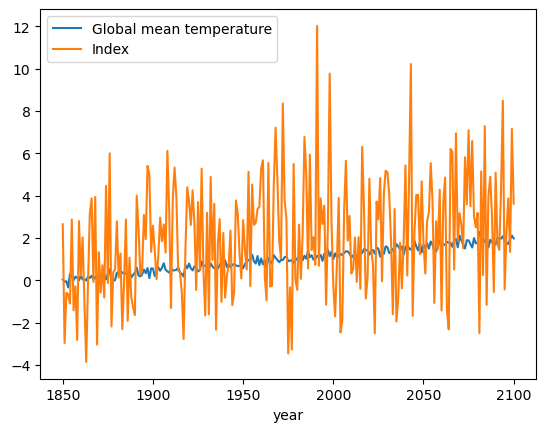

In [3]:
t_glob.plot(label="Global mean temperature")

t_index.plot(label="Index")

plt.legend()

### apply 4-year rolling mean to tas

only if there one ensemble member

In [4]:
t_glob_smooth = t_glob.rolling(year=4).mean()

In [5]:
def remove_nans(*args):
    isnull = False

    for arg in args:
        isnull = isnull | np.isnan(arg)
    notnull = ~isnull
    return [arg[notnull] for arg in args]

## Setup

In [6]:
# set config values

# time period to analyze
time_period = slice(1850, 2022)

# only for dist_cov.distributions.gev_cov: constrain the shape parameter
constrain = 0.3

# current year (to get the global mean temperature)
year_now = 2022

# temperature difference between `year_now` and pre-industrial
warming_level = -1.2

# return time of the event in the current climate (to estimate the event magnitude)
# this also acts as 'bias correction'
return_time = 25  # years

## Get data

In [7]:
# get data
tglob = t_glob_smooth.sel(year=time_period)

index = t_index.sel(year=time_period)

# remove nans (from the smoothing)
tglob, index = remove_nans(tglob, index)

## Initialize the distribution

In [8]:
stat_model = dist_cov.distributions.gev_cov(index, tglob, constrain=constrain)

## Maximum likelihood estimate

In [9]:
params_mle = stat_model.fit()
print("MLE fit:", params_mle)

MLE fit: [-0.12200912 -0.20721364  1.22481705  2.31344342]


## MCMC sampling

In [10]:
# use an MCMC sampler to estimate the params & their uncertainty
# NOTE: in production: use more samples!
sampler = dist_cov.sample.run_mcmc(stat_model, burn_in=125, production=250)

Running burn-in...
Running production...


Get the best estimate of the mcmc-sampled params:

In [11]:
# get the best estimate
params_best_estimate = np.median(sampler.flatchain, axis=0)

print("Beset estimate:")
print(stat_model.param_names)
print(np.round(params_best_estimate, 3))

Beset estimate:
['shape', 'b0', 'b1', 'scale']
[-0.12  -0.228  1.221  2.346]


### Visualize the sampled params

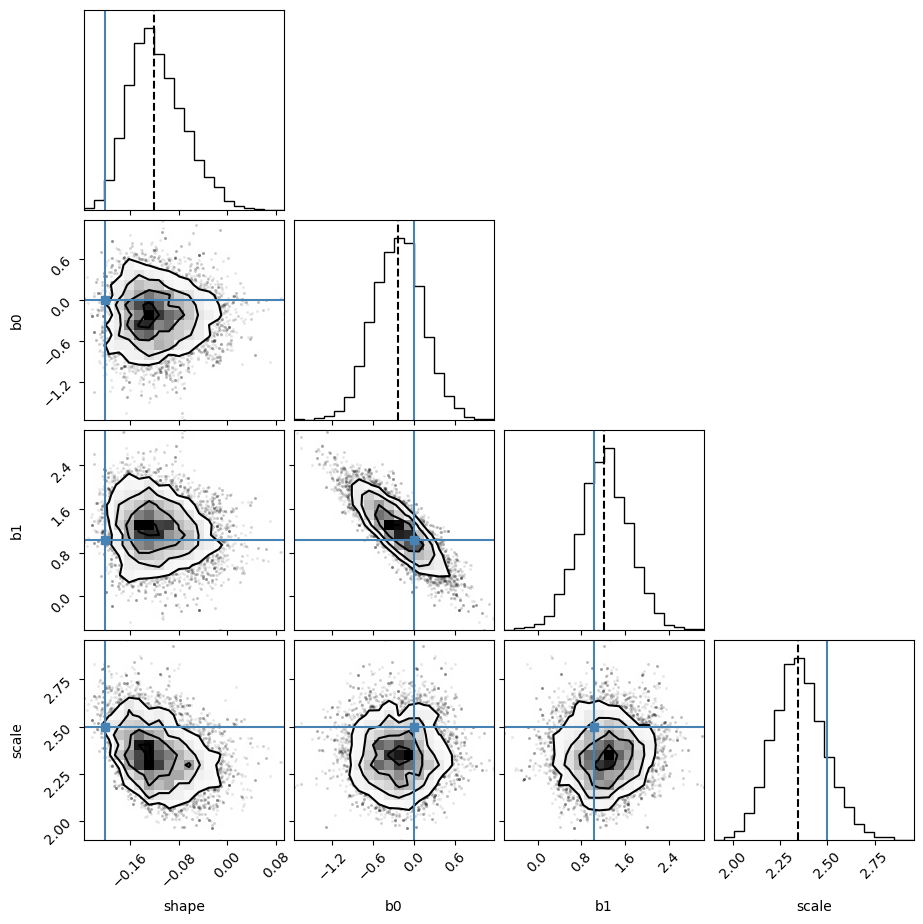

In [12]:
corner.corner(sampler.flatchain, labels=stat_model.param_names, truths=params_orig, quantiles=[0.5])
None

The shape is off. However, the shape param is extremely difficult to estimate, and it is constrained here (which draws it closer to 0). If we fit the whole period, the period, the estimate is better. Also note that the mle and mcmc estimates are close (which is good):

In [13]:
params_mle_full = dist_cov.distributions.gev_cov(t_index, t_glob).fit()

print("params orig:    ", params_orig)
print("params mle:     ", np.round(params_mle, 2))
print("params mcmc:    ", np.round(params_best_estimate, 2))
print("params mle full:", np.round(params_mle_full, 2))

params orig:     (-0.2, 0, 1.025, 2.5)
params mle:      [-0.12 -0.21  1.22  2.31]
params mcmc:     [-0.12 -0.23  1.22  2.35]
params mle full: [-0.16 -0.13  1.09  2.44]


## Get the global mean temperature

In the event year (`year_now`) and in a pre-industrial climate:

In [14]:
tglob_now = tglob.sel(year=year_now).item()
tglob_nat = tglob_now + warming_level

print(f"tglob: {tglob_nat:0.2f} vs. {tglob_now:0.2f}")

# calculate the event magnitude from the return time



tglob: 0.16 vs. 1.36


## Estimate the event magnitude


Using the 'inverse survival function' (`isf`), giving the probability of being _above_ a threshold. For an event _below_ a threshold, would use `stat_model.ppf`.

In [15]:
event_magnitude = stat_model.isf(1 / return_time, params_best_estimate, tglob_now)
print(f"event magnitude: {event_magnitude:0.3f}")

event magnitude: 7.664


Here we use the `params_best_estimate` - you could also pass the full `sampler.flatchain` to `stat_model.isf` and use its `median` (or even make use of the uncertainty in the event magnitude).

## Calculate the event probability

Estimate the probabilities, given the event magnitude using the survival function, as we are _above_ a threshold. For an event _below_ a threshold, would use `stat_model.cdf`

In [16]:
p_nat = stat_model.sf(event_magnitude, sampler.flatchain, tglob_nat)
p_now = stat_model.sf(event_magnitude, sampler.flatchain, tglob_now)

## Plot event probability

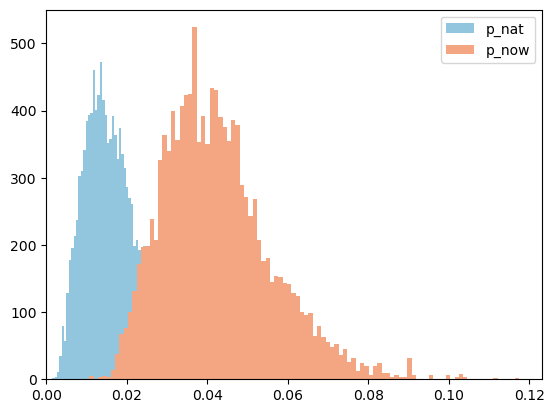

In [17]:
f, ax = plt.subplots()

ax.hist(p_nat, bins=100, label="p_nat", color="#92c5de")
ax.hist(p_now, bins=100, label="p_now", color="#f4a582")

ax.set_xlim(0, None)
ax.legend()

## Calculate the probability ratio

In [18]:
# calculate the probaility ratio
with warnings.catch_warnings():
    # p_nat can be zero
    warnings.filterwarnings("ignore", r"invalid value|divide by zero")

    PR = p_now / p_nat

print("PR: ", dist_cov.utils.fmt_param_range(PR, alpha=0.05))

PR:   2.532 ( 1.256 to  6.895)


Note: PR can contain `inf` (from `1/0`) and `nan` (from `0/0`).

## Plot PR

Text(0.5, 0, 'Probability ratio (PR)')

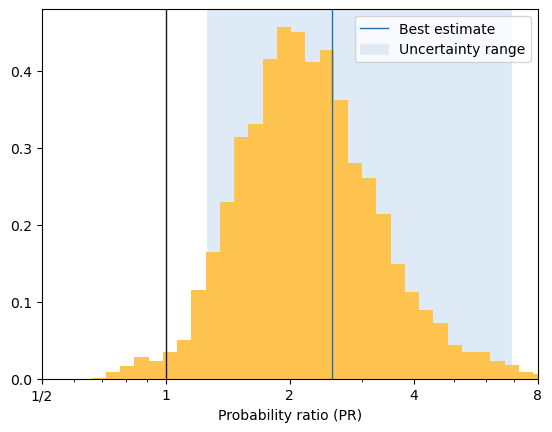

In [19]:
alpha = 0.05

be, lb, ub = dist_cov.utils.param_range(PR, alpha=alpha)

PR_no_inf = PR[~np.isinf(PR)]

# create logarithmic bins
mn, mx = np.nanmin(PR_no_inf), np.nanmax(PR_no_inf)

logbins = np.geomspace(mn, mx, 50)


# ===

f, ax = plt.subplots()

ax.hist(PR, bins=logbins, density=True, color="#fec44f")

ax.axvline(be, color="#2171b5", lw=1, label="Best estimate")
ax.axvspan(lb, ub, color="#deebf7", lw=0.5, zorder=0.1, label="Uncertainty range")

ax.legend()

ax.axvline(1, color="0.1", lw=1)


# set a logscale to by symmetric around 1
ax.set_xscale("log")

ax.set_xticks([1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8])
ax.set_xticklabels(["1/8", "1/4", "1/2", "1", "2", "4", "8"])

ax.set_xlim(1 / 2, 8)

ax.set_xlabel("Probability ratio (PR)")

## Calculate intensity change

In [20]:
# calculate change in intensity (of index, not Tglob)
mu_nat = stat_model.predict(sampler.flatchain, tglob_nat)
mu_now = stat_model.predict(sampler.flatchain, tglob_now)

print("Intensity:")
print("- nat  : ", dist_cov.utils.fmt_param_range(mu_nat, alpha=0.05))
print("- now  : ", dist_cov.utils.fmt_param_range(mu_now, alpha=0.05))
delta_mu = mu_now - mu_nat
print("- delta: ", dist_cov.utils.fmt_param_range(delta_mu, alpha=0.05))

Intensity:
- nat  :  -0.034 (-0.638 to  0.576)
- now  :   1.422 ( 0.680 to  2.185)
- delta:   1.466 ( 0.386 to  2.547)
